In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
import matplotlib.lines as mlines
%matplotlib inline
from ovejero import model_trainer, data_tools, bnn_inference
import corner

def NOTIMPLEMENTED():
    raise NotImplementedError('Must specify config path')

# Testing the Performance of a Model That Has Been Fit

__Author:__ Sebastian Wagner-Carena

__Created:__ 11/14/2019

__Last Run:__ 11/14/2019

__Goals:__ Learn how to test the performance of a trained model on the validation set.

__Before running this notebook:__ Run the Train_Toy_Model notebook to understand how to train a model. Then train a model with whatever configuration you want. You will have to add the path to the config file in this notebook.

In [4]:
# First specify the config path
config_path = '../configs/t1_local.json'#NOTIMPLEMENTED()

# Check that the config has what you need
cfg = model_trainer.load_config(config_path)

# The InferenceClass will do all the heavy lifting of preparing the model from the configuration file,
# initializing the validation dataset, and providing outputs correctly marginalized over the BNN uncertainties.
bnn_infer = bnn_inference.InferenceClass(cfg)

# Now we just have to ask the InferenceClass to spin up some samples from our BNN. The more samples, the more
# accurate our plots and metrics will be. The right value to use unfortunately requires a bit of trial and error.
# 1000 is a good starting point though.
num_samples = 100
bnn_infer.gen_samples(num_samples)

100%|██████████| 100/100 [01:14<00:00,  1.59it/s]


Now that we set up our infastructure, the first thing we want to do is inspect the statistics of our network's performance over the validation set.

In [ ]:
bnn_infer.report_stats()

We can also inspect a coverage plot of our parameters. If our model is performing well, we expect our data to roughly follow the 68-95-99.7 rule.

In [ ]:
bnn_infer.gen_coverage_plots()

Another good check is to see the posterior of some example images.

In [ ]:
image_index = 5
bnn_infer.plot_posterior_contours(image_index)

It's important to understand where our uncertainty is coming from. We can inspect wether our uncertainty is dominated by aleatoric or epistemic sources. 

In [ ]:
bnn_infer.comp_al_ep_unc()

At the end what we want our network's posterior to be well calibrated. That means that the truth should be a representative draw from the distribution we're predicting. The exact sampling that goes into the calibration plot is complicated, but the x axis repesents how much of the data the model expects to fall within a certain region of our posterior, and the y axis represents how much data actually falls within that region. Ideally this would be a straight line (y=x), but in practice our model is likely to be overconfident, underconfident, or some combination of both. The lower right hand corner of our plot represents overconfidence, and the upper right hand corner represents underconfidence.

0.030272569299841734


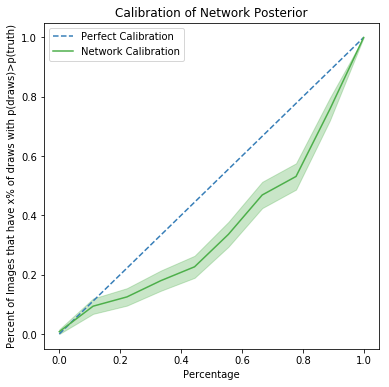

In [9]:
color_map = ["#377eb8", "#4daf4a"]
n_perc_points = 10
fig = bnn_infer.plot_calibration(color_map=color_map,n_perc_points=n_perc_points)

We could repeat the same plotting 

To get a better feel for the calibration plot, we can repeat the same analysis on some toy 2D models. We can start with a biased 2D posterior prediction.

In [ ]:
# First we'll make a class to generate our comparison
def plot_toy_model_calibration(data_mean,data_cov,post_mean,post_cov,toy_batch_size,n_draws,
                              fit_guass_data=False):
    bnn_toy = bnn_inference.InferenceClass(cfg)
    # We generate our toy data 
    data = np.random.multivariate_normal(data_mean,data_cov,(toy_batch_size))

    # Now we generate our posterior means and covariances
    post_samples = np.random.multivariate_normal(post_mean,post_cov,(n_draws,toy_batch_size))

    # We change our bnn inference instance to have these values
    bnn_toy.samples_init = True
    bnn_toy.y_pred = np.mean(post_samples,axis=0)
    bnn_toy.predict_samps = post_samples
    bnn_toy.y_test = data
    
    # We can visualize the true data and the posterior, and compare that to the calibration plot.
    color_map=["#377eb8", "#4daf4a"]
    fig = corner.corner(post_samples.reshape(-1,2),bins=20,labels=['x','y'],show_titles=False, plot_datapoints=False,
                  label_kwargs=dict(fontsize=13),levels=[0.68,0.95],dpi=1600, 
                  color=color_map[0],fill_contours=True,range=[[-6,6],[-6,6]])
    fig.axes[2].plot(data[:,0],data[:,1],'.',c=color_map[1],alpha=0.1)
    data_line = mlines.Line2D([], [], color=color_map[0], label='Posterior')
    post_line = mlines.Line2D([], [], color=color_map[1], label='Data')
    plt.legend(handles=[data_line,post_line], bbox_to_anchor=(0., 1.0, 1., .0), loc=4,fontsize=15.0)
    plt.show()
    bnn_toy.plot_calibration(n_perc_points=30)

In [ ]:
# We start with our offset posterior
data_mean = np.zeros(2)
data_cov = np.eye(2)
toy_batch_size = 10000
n_draws = 1000
post_mean = np.ones(2)*2
post_cov=np.eye(2)
plot_toy_model_calibration(data_mean,data_cov,post_mean,post_cov,toy_batch_size,n_draws)

The posterior we're predicting is offset from the truth, so our model is consistently overconfident. We can repeat the exercise with a posterior that is correctly centered but has a much tighter contour. We still expect our model to be overconfident.

In [ ]:
data_mean = np.zeros(2)
data_cov = np.eye(2)
toy_batch_size = 10000
n_draws = 1000
post_mean = np.zeros(2)
post_cov=np.eye(2)*0.3
plot_toy_model_calibration(data_mean,data_cov,post_mean,post_cov,toy_batch_size,n_draws = 1000)

Once again, our model is overconfident. We can similary see what happens when our model is underconfident by expanding our contours.

In [ ]:
data_mean = np.zeros(2)
data_cov = np.eye(2)
toy_batch_size = 10000
n_draws = 1000
post_mean = np.zeros(2)
post_cov=np.eye(2)*3
plot_toy_model_calibration(data_mean,data_cov,post_mean,post_cov,toy_batch_size,n_draws)

The model posterior here is underconfident - almost 90% of the data falls within the 1 sigma countour. We can look at a more realistic example - a Gaussian posterior with no covariance trying to fit data with covariance.

In [ ]:
# We start with our offset posterior
data_mean = np.zeros(2)
data_cov = np.array([[1,0.99],[0.99,1]])
toy_batch_size = 10000
n_draws = 1000
post_mean = np.zeros(2)
post_cov=np.diag(np.std(np.random.multivariate_normal(data_mean,data_cov,(toy_batch_size)),axis=0))
plot_toy_model_calibration(data_mean,data_cov,post_mean,post_cov,toy_batch_size,n_draws)

This comes off mostly as underconfidence by our network - it's not capturing the extreme covariance in the data, causing the networks contours to be too large in the inner region. Note that for the largest percentiles our network is slightly overconfident - the extreme diagonality of our true distribution leads to many low probability points.

Another issue our network may have is that the posterior we pick is not sufficiently multimodal to capture the true distribution of the data (or the multimodality is poorly tuned). We can see what this looks like by fitting a full covariance matrix posterior to multimodal data.

In [2]:
# First we'll make a class to generate our comparison
def plot_toy_model_calibration_gm(data_means,data_covs,post_mean,post_cov,toy_batch_size,ps,n_draws,
                              fit_guass_data=False):
    bnn_toy = bnn_inference.InferenceClass(cfg)
    # We generate our toy data 
    data = []
    for dmi in range(len(data_means)):
        data.append(np.random.multivariate_normal(data_means[dmi],data_covs[dmi],(int(toy_batch_size*ps[dmi]))))
    data = np.concatenate(data,axis=0)
    
    if fit_guass_data == True:
        post_mean = np.mean(data,axis=0)
        post_cov=np.diag(np.std(data,axis=0))

    # Now we generate our posterior means and covariances
    post_samples = np.random.multivariate_normal(post_mean,post_cov,(n_draws,toy_batch_size))

    # We change our bnn inference instance to have these values
    bnn_toy.samples_init = True
    bnn_toy.y_pred = np.mean(post_samples,axis=0)
    bnn_toy.predict_samps = post_samples
    bnn_toy.y_test = data
    
    # We can visualize the true data and the posterior, and compare that to the calibration plot.
    color_map=["#377eb8", "#4daf4a"]
    fig = corner.corner(post_samples.reshape((-1,2)),bins=20,labels=['x','y'],show_titles=False, 
                        plot_datapoints=False,label_kwargs=dict(fontsize=13),levels=[0.68,0.95],dpi=1600, 
                        color=color_map[0],fill_contours=True,range=[[-6,6],[-6,6]])
    fig.axes[2].plot(data[:,0],data[:,1],'.',c=color_map[1],alpha=0.1)
    data_line = mlines.Line2D([], [], color=color_map[0], label='Posterior')
    post_line = mlines.Line2D([], [], color=color_map[1], label='Data')
    plt.legend(handles=[data_line,post_line], bbox_to_anchor=(0., 1.0, 1., .0), loc=4,fontsize=15.0)
    plt.show()
    bnn_toy.plot_calibration(n_perc_points=30)

In [3]:
# We start with our offset posterior
data_means = [np.ones(2)*3,np.zeros(2)]
data_covs = [np.array([[0.4,0],[0,0.4]]),np.array([[0.4,0],[0,0.4]])]
ps = [0.9,0.1]
toy_batch_size = 10000
n_draws = 1000

data = []
for dmi in range(len(data_means)):
    data.append(np.random.multivariate_normal(data_means[dmi],data_covs[dmi],(toy_batch_size//len(
    data_mean))))
data = np.concatenate(data,axis=0)

post_mean = np.mean(data,axis=0)
post_cov=np.diag(np.std(data,axis=0))
plot_toy_model_calibration_gm(data_means,data_covs,post_mean,post_cov,toy_batch_size,ps,n_draws,fit_guass_data=True)

NameError: name 'data_mean' is not defined

In [ ]:
# We start with our offset posterior
data_means = [np.ones(2)*3,np.zeros(2)]
data_covs = [np.array([[0.4,0],[0,0.4]]),np.array([[0.4,0],[0,0.4]])]
ps = [0.7,0.3]
toy_batch_size = 10000
n_draws = 1000

data = []
for dmi in range(len(data_means)):
    data.append(np.random.multivariate_normal(data_means[dmi],data_covs[dmi],(toy_batch_size//len(
    data_mean))))
data = np.concatenate(data,axis=0)

post_mean = np.mean(data,axis=0)
post_cov=np.diag(np.std(data,axis=0))
plot_toy_model_calibration_gm(data_means,data_covs,post_mean,post_cov,toy_batch_size,ps,n_draws,fit_guass_data=True)